I am going to follow the regression example in this tutorial to start figuring out nolearn:  
http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

use the nolearn environment (source activate nolearn) to run this notebook  
Documentation: https://github.com/dnouri/nolearn/

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasagne
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet
from sklearn.datasets import make_regression

%matplotlib inline

#### Eventually, make this into a function that reads the data, cleans it appropriately, shuffles and normalizes it, and splits it into training/test sets

In [2]:
# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
x = pd.read_csv('../parameters_250000.txt', sep=' ')
y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
y = y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)

In [3]:
x = x.values.astype(np.float32)
y = y.values.astype(np.float32)

In [4]:
print x.shape, y.shape

(250000, 4) (250000, 30)


In [5]:
# Standardize and shuffle
mu = np.mean(x, axis=0)
sigma = np.std(x, axis=0)
x_norm = (x-mu)/sigma

combined = np.concatenate((x_norm, y), axis=1)
np.random.shuffle(combined)

x = combined[:,:4]
y = combined[:, 4:]

## Notes on choosing architechture, hyperparameters, etc.

##### Number of Hidden Layers:
Problems that require two hidden layers are rarely encountered, however, NNs with two hidden layers can represent functions with any kind of shape.  There is currently no theoretical reason to use neural networks with any more than two hidden layers.  (from https://web.archive.org/web/20140721050413/http://www.heatonresearch.com/node/707)

##### Number of neurons in hidden layers:
There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

-  The number of hidden neurons should be between the size of the input layer and the size of the output layer. 
-  The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. 
-  The number of hidden neurons should be less than twice the size of the input layer. 
-  Additional rule of thumb for determining an upperbound on the number of hidden neurons that won't result in overfitting is: 

$$ N_h = \frac{N_s}{alpha*(N_i + N_o)} $$

&nbsp;&nbsp;&nbsp;&nbsp; $N_i$ = number of input neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_o$ = number of output neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_s$ = number of samples in training data set
&nbsp;&nbsp;&nbsp;&nbsp; alpha = arbitrary scaling factor (usually between 2-10)

##### Choosing the Learning Rate
-  First, estimate a threshold value at which the cost on the traning data immediately begins decreasing (do this by changing learning rate by orders of magnitude until you get a value where the cost increases during the first few epochs)
-  This threshold value changes with network architechture and whether the training data is normalized.  Small changes below the threshold value appear to have significant impacts on the results...
-  I need to do more digging into nolearn to determine if I can specify a learning rate schedule, or otherwise adjust the learning rate during training  
--> turns out you can do this fairly easily: see Daniel Nouri's tutorial linked above.

##### Regularization Parameter
Am I able to add regularization with nolearn?  If so, first figure out learning rate without regularization, then add it.  Start with lambda = 1.0, then increase or decrease by factors of 10 to improve performance on the validation data.  After finding best lambda, return and re-optimize the learning rate again.
https://groups.google.com/forum/#!topic/lasagne-users/B3w6_EU9qlI  
https://www.kaggle.com/c/otto-group-product-classification-challenge/forums/t/14139/does-anyone-know-how-to-make-l1-and-l2-regularization-work-for-lasagne  

Should I just add dropout instead?  Both dropout and regularization only make sense if we have a network that is overfitting, so right now it doesn't look like I need it until I can make my network overfit...

In [ ]:
lasagne.objectives.squared_error

In [51]:
l = InputLayer(shape=(None, x.shape[1]))
l = DenseLayer(l, num_units=18, nonlinearity=nonlinearities.sigmoid)
l = DenseLayer(l, num_units=y.shape[1],
               nonlinearity=nonlinearities.linear)
# NeuralNet automatically splits the data provided in x into a training
# and a validation set, using 20% of the samples for validation. 
# You can adjust this ratio by overriding the eval_size=0.2 parameter.
net = NeuralNet(l, regression=True, update_learning_rate=0.5, verbose=1,
                max_epochs=100)
                #, update_momentum=0.9, update=lasagne.updates.sgd)
net.fit(x, y)
print(net.score(x, y))

# The table that is printed shows the current loss (MSE) on the training and
# validation sets.

# Neural Network with 660 learnable parameters

## Layer information

  #    name    size
---  ------  ------
  0               4
                 18
                 30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.00178       0.00107      1.66442  0.46s
      2       0.00088       0.00078      1.11972  0.46s
      3       0.00070       0.00065      1.07629  0.46s
      4       0.00060       0.00058      1.03891  0.47s
      5       0.00055       0.00054      1.02459  0.47s
      6       0.00051       0.00050      1.02000  0.46s
      7       0.00048       0.00047      1.01729  0.46s
      8       0.00045       0.00044      1.01489  0.45s
      9       0.00042       0.00042      1.01295  0.46s
     10       0.00040       0.00039      1.01128  0.45s
     11       0.00038       0.00037      1.00906  0.45s
     12       0.00036       0.00036      1.00613  0.46s
     13       0.00035       0.00034      1.0034

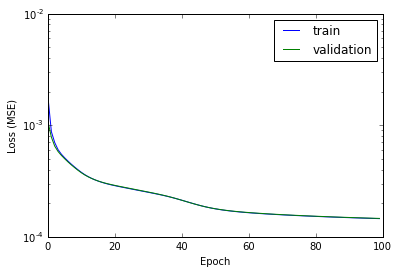

In [55]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])

plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')


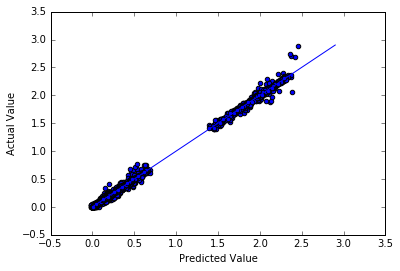

In [53]:
y_predictions = net.predict(x)
# y_predictions.shape
plt.scatter(y_predictions[:1000,:].flatten(), y[:1000,:].flatten())
plt.plot([np.min(y),np.max(y)],[np.min(y),np.max(y)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

#### Next steps:

- Separate a test set from the training data (x and y above)
- What objective function is being used by nolearn?  Default is nesterov momentum
- Default loss function for regression is MSE
- Optimize
- pickle the trained model when it is done